# Adversarial Discriminative Domain Adaptation for Gaussian Domains

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

### Source domain

In [3]:
N_source = 100
N_class0 = N_source // 2
N_class1 = N_source - N_class0

In [4]:
mean0 = [-1, -1]
mean1 = [-1, 1]

std = 0.1
cov0 = np.eye(2) * std
cov1 = np.eye(2) * std

In [5]:
x0, y0 = np.random.multivariate_normal(mean0, cov0, N_class1).T
x1, y1 = np.random.multivariate_normal(mean1, cov1, N_class0).T
X0 = np.concatenate([x0.reshape(len(x0), 1), y0.reshape(len(y0), 1)], axis=1)
X1 = np.concatenate([x1.reshape(len(x1), 1), y1.reshape(len(y1), 1)], axis=1)

X_source = np.concatenate([X0, X1], axis=0)
Y_source = np.array([0]*N_class0 + [1]*N_class1)

### Target domain

In [6]:
N_target = 100
N_class0 = N_target // 2
N_class1 = N_target - N_class0

In [7]:
mean0 = [1, 1]
mean1 = [1, -1]

std = 0.1
cov0 = np.eye(2) * std
cov1 = np.eye(2) * std

In [8]:
# x0, y0 = np.random.multivariate_normal(mean0, cov0, N_class1).T
# x1, y1 = np.random.multivariate_normal(mean1, cov1, N_class0).T
# X0 = np.concatenate([x0.reshape(len(x0), 1), y0.reshape(len(y0), 1)], axis=1)
# X1 = np.concatenate([x1.reshape(len(x1), 1), y1.reshape(len(y1), 1)], axis=1)

# X_target = np.concatenate([X0, X1], axis=0)
# Y_target = np.array([0]*N_class0 + [1]*N_class1)

X_target = np.apply_along_axis(lambda x: np.array([x[0]+2,x[1]]), 1, X_source)
Y_target = Y_source

### Display the dataset

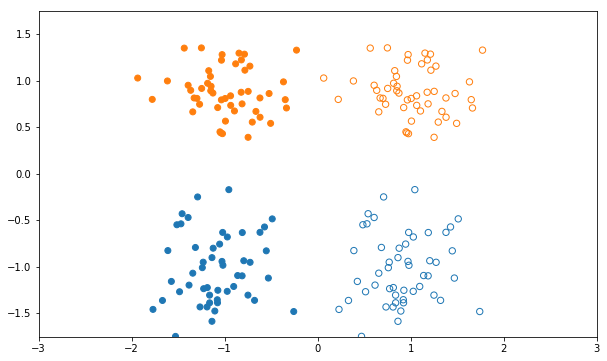

In [9]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.axis("equal")
plt.axis([-3,3,-3,3])

plt.scatter(X_source[:,0], X_source[:,1], color=colormap[Y_source])
plt.scatter(X_target[:,0], X_target[:,1], s=40, facecolors='none', edgecolor=colormap[Y_source])

## Create the model

### Placeholders

In [10]:
S_input = tf.placeholder(tf.float32, shape=[None, 2], name='X_source')
T_input = tf.placeholder(tf.float32, shape=[None, 2], name='X_target')
S_labels = tf.placeholder(tf.int32, shape=[None], name='S_labels')
T_labels = tf.placeholder(tf.int32, shape=[None], name='T_labels')

### Discriminator Network

In [11]:
D_W1 = tf.get_variable('D_W1', shape=[2,2], initializer=tf.random_normal_initializer())
D_b1 = tf.get_variable('D_b1', shape=[2], initializer=tf.zeros_initializer())

D_W2 = tf.get_variable('D_W2', shape=[2, 20], initializer=tf.random_normal_initializer())
D_b2 = tf.get_variable('D_b2', shape=[20], initializer=tf.random_normal_initializer())

D_W3 = tf.get_variable('D_W3', shape=[20, 2], initializer=tf.random_normal_initializer())
D_b3 = tf.get_variable('D_b3', shape=[2], initializer=tf.random_normal_initializer())

In [12]:
theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

In [13]:
def discriminator_nn(x):  
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_output = tf.nn.sigmoid(D_logit)
    
    return D_output

### Target Network

In [14]:
T_W1 = tf.get_variable('T_W1', initializer=tf.eye(2, dtype="float32"))
T_b1 = tf.get_variable('T_b1', shape=[2], initializer=tf.zeros_initializer())

In [15]:
theta_T = [T_W1, T_b1]

In [16]:
def target_nn(x):  
    T_output = tf.matmul(x, T_W1) + T_b1
    
    return T_output

### Losses and solver

In [17]:
T_output = target_nn(T_input)
D_source = discriminator_nn(S_input)
D_target = discriminator_nn(T_output)

In [18]:
def select(tensor, labels):
    """ Input: (N,2) tensor and a (N,) labels tensor
        Output: (N,1) tensor, whose each element i correspond to the column labels[i] of 
        Ex : [[12,4],[7,42]], [0,1] => [12,42]
    """
    mask = tf.cast(tf.concat([tf.expand_dims(labels,1), 1-tf.expand_dims(labels,1)], axis=1), bool)
    return tf.boolean_mask(tensor, mask)

In [19]:
def log(tensor):
    return tf.log(tf.maximum(tensor, 1e-9))

In [20]:
D_loss = -tf.reduce_mean(select(log(D_source), S_labels) + select(log(1. - D_target), T_labels))
T_loss = -tf.reduce_mean(select(log(D_target), T_labels))

In [21]:
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
T_solver = tf.train.AdamOptimizer().minimize(T_loss, var_list=theta_T)

/home/artix41/.local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Execute the model

In [22]:
sess = tf.InteractiveSession()

In [23]:
sess.run(tf.global_variables_initializer())
D_loss_list = []
T_loss_list = []

In [34]:
nb_iter = 200
nb_iter_d = 100
nb_iter_g = 10
nb_samples = 10
T_loss_curr = 0.001
D_loss_curr = 0.001

for i in range(nb_iter):
    for k in range(nb_iter_d):
        sample_idx_source = np.random.choice(len(X_source), nb_samples)
        sample_idx_target = np.random.choice(len(X_target), nb_samples)
        sample_source = X_source[sample_idx_source]
        sample_target = X_target[sample_idx_target]
        sample_labels_source = Y_source[sample_idx_source]
        sample_labels_target = Y_target[sample_idx_target]
        
        _, D_loss_curr = sess.run([D_solver, D_loss],feed_dict={S_input: sample_source, 
                                                                T_input: sample_target, 
                                                                S_labels: sample_labels_source,
                                                                T_labels: sample_labels_target
                                                               })
    
    for k in range(nb_iter_g):
        sample_idx_target = np.random.choice(len(X_target), 10*nb_samples)
        sample_target = X_target[sample_idx_target]
        sample_labels_target = Y_target[sample_idx_target]
        _, T_loss_curr = sess.run([T_solver, T_loss], feed_dict={T_input: sample_target, 
                                                                 T_labels: sample_labels_target})
    
    D_loss_list.append(D_loss_curr)
    T_loss_list.append(T_loss_curr)
    if i % (nb_iter//10) == 0:
        print('Iter: {}'.format(i))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('T_loss: {:.4}'.format(T_loss_curr))
        print()

Iter: 0
D loss: 1.386
T_loss: 0.7077

Iter: 20
D loss: 1.402
T_loss: 0.6889

Iter: 40
D loss: 1.4
T_loss: 0.6727

Iter: 60
D loss: 1.369
T_loss: 0.6878

Iter: 80
D loss: 1.385
T_loss: 0.716

Iter: 100
D loss: 1.457
T_loss: 0.682

Iter: 120
D loss: 1.385
T_loss: 0.6872

Iter: 140
D loss: 1.38
T_loss: 0.7008

Iter: 160
D loss: 1.344
T_loss: 0.7108

Iter: 180
D loss: 1.42
T_loss: 0.7



## Display the results

In [35]:
X_target_trans = sess.run(T_output, feed_dict={T_input: X_target})

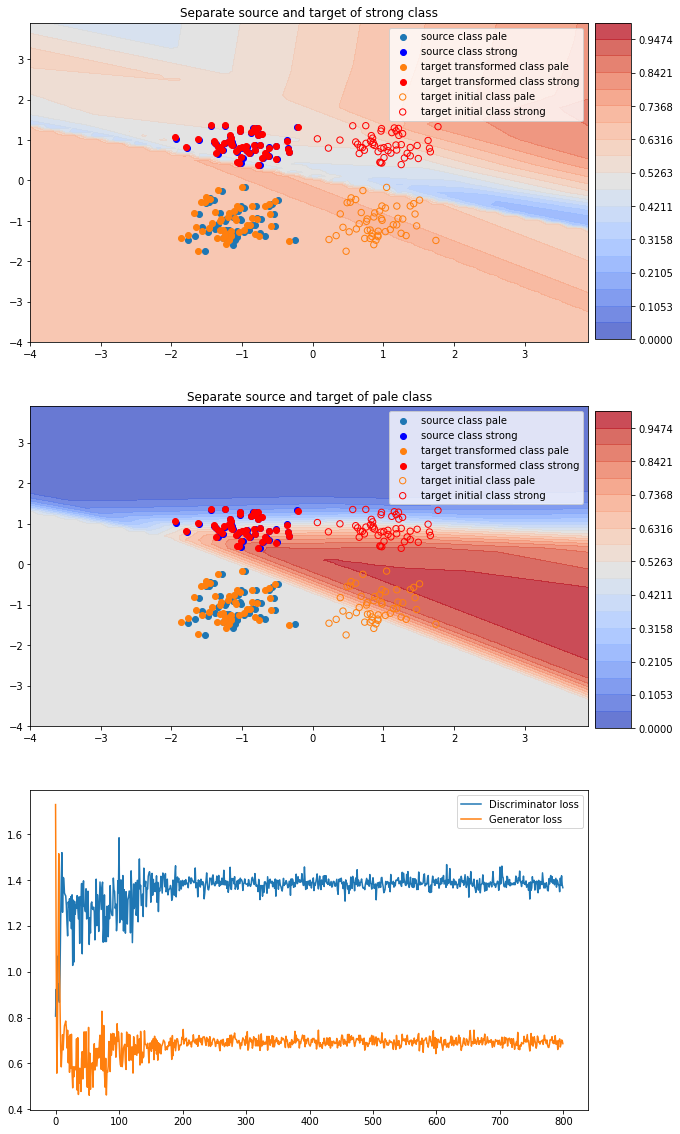

In [36]:
plt.rcParams['figure.figsize'] = (10, 20)

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

levels = np.linspace(0,1,20)
cm = plt.cm.coolwarm
Z = [None]*2
Z[0] = sess.run(D_source, feed_dict={S_input: np.c_[xx.ravel(), yy.ravel()]})[:,0].reshape(xx.shape)
Z[1] = sess.run(D_source, feed_dict={S_input: np.c_[xx.ravel(), yy.ravel()]})[:,1].reshape(xx.shape)

f, (a0, a1, a2) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[1, 1, 1]})

cont = [None]*2
cont[0] = a0.contourf(xx, yy, 1-Z[0], levels, cmap=cm, alpha=.8)
cont[1] = a1.contourf(xx, yy, 1-Z[1], levels, cmap=cm, alpha=.8)

cm_source = np.array([colormap[0], "blue"])
cm_target = np.array([colormap[1], "red"])

a0.scatter(X_source[Y_source==0,0], X_source[Y_source==0,1], color=cm_source[0], label="source class pale")
a0.scatter(X_source[Y_source==1,0], X_source[Y_source==1,1], color=cm_source[1], label="source class strong")
a0.scatter(X_target_trans[Y_target==0,0], X_target_trans[Y_target==0,1], color=cm_target[0], label="target transformed class pale")
a0.scatter(X_target_trans[Y_target==1,0], X_target_trans[Y_target==1,1], color=cm_target[1], label="target transformed class strong")
a0.scatter(X_target[Y_target==0,0], X_target[Y_target==0,1], s=40, facecolors='none', edgecolor=cm_target[0], label="target initial class pale")
a0.scatter(X_target[Y_target==1,0], X_target[Y_target==1,1], s=40, facecolors='none', edgecolor=cm_target[1], label="target initial class strong")

a0.legend()
a0.set_title("Separate source and target of strong class")
cax = f.add_axes([0.91,0.66,0.05,0.22])
f.colorbar(cont[0], cax=cax, orientation="vertical")

a1.scatter(X_source[Y_source==0,0], X_source[Y_source==0,1], color=cm_source[0], label="source class pale")
a1.scatter(X_source[Y_source==1,0], X_source[Y_source==1,1], color=cm_source[1], label="source class strong")
a1.scatter(X_target_trans[Y_target==0,0], X_target_trans[Y_target==0,1], color=cm_target[0], label="target transformed class pale")
a1.scatter(X_target_trans[Y_target==1,0], X_target_trans[Y_target==1,1], color=cm_target[1], label="target transformed class strong")
a1.scatter(X_target[Y_target==0,0], X_target[Y_target==0,1], s=40, facecolors='none', edgecolor=cm_target[0], label="target initial class pale")
a1.scatter(X_target[Y_target==1,0], X_target[Y_target==1,1], s=40, facecolors='none', edgecolor=cm_target[1], label="target initial class strong")

a1.legend()
a1.set_title("Separate source and target of pale class")
cax = f.add_axes([0.91,0.39,0.05,0.22])
f.colorbar(cont[1], cax=cax, orientation="vertical")

a2.plot(D_loss_list, label="Discriminator loss")
a2.plot(T_loss_list, label="Generator loss")
a2.legend()

In [30]:
f.savefig("screenshots/S-D2-2-20-T1-2_v2.png")

## Tests divers

In [59]:
#sess.run(D_source, feed_dict={S_input: X_source})[50:100]

In [60]:
sess.run(select(tf.log(D_source), S_labels),feed_dict={S_input: X_source, S_labels: Y_source})

array([-0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.68835431, -0.68835431, -0.68835431, -0.68835431, -0.68835431,
       -0.69441378, -0.69441378, -0.69441378, -0.69441378, -0.69441378,
       -0.69441378, -0.69441378, -0.69441378, -0.69441378, -0.69441378,
       -0.69441378, -0.69441378, -0.69441378, -0.69441378, -0.69441378,
       -0.69441378, -0.69441378, -0.69441378, -0.69441378, -0.69

In [37]:
np.dot(sess.run(T_W1), [1,1])

array([ 0.98488419,  1.03503277])

In [38]:
sess.run(T_b1)

array([-2.05272341,  0.03614062], dtype=float32)